# Lambda School Data Science - Logistic Regression

Logistic regression is the baseline for classification models, as well as a handy way to predict probabilities (since those too live in the unit interval). While relatively simple, it is also the foundation for more sophisticated classification techniques such as neural networks (many of which can effectively be thought of as networks of logistic models). notes

## Lecture - Where Linear goes Wrong
### Return of the Titanic 🚢

You've likely already explored the rich dataset that is the Titanic - let's use regression and try to predict survival with it. The data is [available from Kaggle](https://www.kaggle.com/c/titanic/data), so we'll also play a bit with [the Kaggle API](https://github.com/Kaggle/kaggle-api).

### Get data, option 1: Kaggle API

#### Sign up for Kaggle and get an API token
1. [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. 
2. [Follow these instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to create a Kaggle “API Token” and download your `kaggle.json` file. If you are using Anaconda, put the file in the directory specified in the instructions.

_This will enable you to download data directly from Kaggle. If you run into problems, don’t worry — I’ll give you an easy alternative way to download today’s data, so you can still follow along with the lecture hands-on. And then we’ll help you through the Kaggle process after the lecture._

#### Put `kaggle.json` in the correct location

- ***If you're using Anaconda,*** put the file in the directory specified in the [instructions](https://github.com/Kaggle/kaggle-api#api-credentials).

- ***If you're using Google Colab,*** upload the file to your Google Drive, and run this cell:

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
env: KAGGLE_CONFIG_DIR=/content/drive/My Drive/


#### Install the Kaggle API package and use it to get the data

You also have to join the Titanic competition to have access to the data

In [2]:
!pip install kaggle

In [3]:
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 54.4MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 20.0MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.30MB/s]


### Get data, option 2: Download from the competition page
1. [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. 
2. [Go to the Titanic competition page](https://www.kaggle.com/c/titanic) to download the [data](https://www.kaggle.com/c/titanic/data).

### Get data, option 3: Use Seaborn

```
import seaborn as sns
train = sns.load_dataset('titanic')
```

But Seaborn's version of the Titanic dataset is not identical to Kaggle's version, as we'll see during this lesson!

### Read data

In [4]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.shape, test.shape

((891, 12), (418, 11))

Notice that `train.csv` has one more column than `test.csv` : The target, `Survived`.

Kaggle provides test labels, but not test targets. Instead, you submit your test predictions to Kaggle to get your test scores. Why? This is model validaton best practice, makes competitons fair, and helps us learn about over- and under-fitting.

In [5]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,NaN,S
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
379,380,0,3,"Gustafsson, Mr. Karl Gideon",male,19.0,0,0,347069,7.7750,NaN,S
133,134,1,2,"Weisz, Mrs. Leopold (Mathilde Francoise Pede)",female,29.0,1,0,228414,26.0000,NaN,S
328,329,1,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.5250,NaN,S


In [6]:
test.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
70,962,3,"Mulvihill, Miss. Bertha E",female,24.0,0,0,382653,7.7500,NaN,Q
154,1046,3,"Asplund, Master. Filip Oscar",male,13.0,4,2,347077,31.3875,NaN,S
366,1258,3,"Caram, Mr. Joseph",male,NaN,1,0,2689,14.4583,NaN,C
292,1184,3,"Nasr, Mr. Mustafa",male,NaN,0,0,2652,7.2292,NaN,C
303,1195,3,"Pokrnic, Mr. Tome",male,24.0,0,0,315092,8.6625,NaN,S


Do some data exploration. 

About 62% of passengers did not survive.

In [7]:
target = 'Survived'
train[target].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [8]:
train.describe(include='number')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train.describe(exclude='number')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Marechal, Mr. Pierre",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


### How would we try to do this with linear regression?

https://scikit-learn.org/stable/modules/impute.html

We choose a few numeric features, split the data into X and y, impute missing values, and fit a Linear Regression model on the train set.

In [10]:
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.impute import SimpleImputer

features = ['Pclass', 'Age', 'Fare']
target = 'Survived'

X_train = train[features]
y_train = train[target]

X_test = test[features]

# no y_test, kaggle rules

train.shape, X_train.shape, y_train.shape

((891, 12), (891, 3), (891,))

In [0]:
## take care of NaN values

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [12]:
X_train.shape, X_train_imputed.shape, X_test.shape, X_test_imputed.shape

((891, 3), (891, 3), (418, 3), (418, 3))

In [13]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_imputed, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Let's consider a test case. What does our Linear Regression predict for a 1st class, 5 year-old, with a fare of 500?

119% probability of survival.

In [14]:
test_case = np.array([[1, 5, 500]])  # rich five year old in first class
lin_reg.predict(test_case)

array([1.19207871])

Based on the Linear Regression's intercept and coefficients, it will predict probabilities greater than 100%, or less than 0%, given high enough / low enough values for the features.

In [0]:
y_pred = lin_reg.predict(X_test_imputed)

In [16]:
pd.Series(y_pred).describe()

count    418.000000
mean       0.392117
std        0.181876
min        0.011755
25%        0.227341
50%        0.339570
75%        0.516439
max        0.954827
dtype: float64

In [17]:
pd.Series(lin_reg.coef_, X_train.columns)

Pclass   -0.210390
Age      -0.007358
Fare      0.000751
dtype: float64

In [18]:
lin_reg.intercept_

1.063899500003544

### How would we do this with Logistic Regression?

The scikit-learn API is consistent, so the code is similar.

We instantiate our model (here with `LogisticRegression()` instead of `LinearRegression()`)

We use the same method to fit the model on the training data: `.fit(X_train_imputed, y_train)`

We use the same method to make a predict for our test case: `.predict(test_case)` — But this returns different results. Regressors return continuous values, but classifiers return discrete predictions of the class label. In this binary classification problem, our discrete class labels are `0` (did not survive) or `1` (did survive).

Classifiers also have a `.predict_proba` method, which returns predicted probabilities for each class. The probabilities sum to 1. 

We predict ~3% probability that our test case did not surive, and 97% probability that our test case did survive. This result is what we want and expect for our test case: to predict survival, with high probability, but less than 100%.

In [19]:
## logistic regression is better for classification problems
## in fact if you use regression on classification.. that is a rookie error

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)

## prediction for rich five year old, and predictive probablities
log_reg.predict(test_case), log_reg.predict_proba(test_case)

(array([1]), array([[0.02778799, 0.97221201]]))

Logistic Regression calculates predicted probablities between the range of 0 and 1. By default, scikit-learn makes a discrete prediction by returning whichever class had the highest predicted probability for that observation.

In the case of binary classification, this is equivalent to using a threshold of 0.5. However, we could choose a different threshold, for different trade-offs between false positives versus false negatives.

In [20]:
log_reg.predict(X_test_imputed)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,

In [21]:
# look ar probablity they survived

threshold = .5
(log_reg.predict_proba(X_test_imputed)[:,1] > threshold).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,

In [22]:
## show that this is how 'predict' makes predictions.. also giving you possibility
## to set different thresholds if need be.

manual_predictions = (log_reg.predict_proba(X_test_imputed)[:,1] > threshold).astype(int)
direct_predictions = log_reg.predict(X_test_imputed)

all(manual_predictions == direct_predictions)

True

### How accurate is the Logistic Regression?

Scikit-learn estimators provide a convenient method, `.score`. It uses the X features to generate predictions. Then it compares the predictions to the y ground truth labels. Then it returns the score.

For regressors, `.score` returns R^2.

For classifiers, `.score` returns Accuracy.

Our Logistic Regression model has 70% training accuracy. (This is higher than the 62% accuracy we would get with a baseline that predicts every passenger does not survive.)

In [23]:
## r2 only makes sense for regression
## accuracy, only makes sense for classification

score = log_reg.score(X_train_imputed, y_train)
print('Train Accuracy Score: ', score)

Train Accuracy Score:  0.7025813692480359


We don't want to just score our model on the training data.

We cannot calculate a test accuracy score ourselves in this notebook, because Kaggle does not provide test labels.

We could split the train data into train and validation sets. However, we don't have many observations. (Fewer than 1,000.)

As another alternative, we can use cross-validation:

In [24]:
## cross validation made easy!
from sklearn.model_selection import cross_val_score

scores = cross_val_score(log_reg,X_train_imputed, y_train, cv=10)

print('Cross Validation Accuracy scores: ', scores)

Cross Validation Accuracy scores:  [0.63333333 0.62222222 0.68539326 0.71910112 0.69662921 0.69662921
 0.76404494 0.75280899 0.73033708 0.71590909]


We can see a range of scores: 

In [25]:
scores.min(), scores.mean(), scores.max()

(0.6222222222222222, 0.7016408466689366, 0.7640449438202247)

In [26]:
X_train_imputed.shape

(891, 3)

In [0]:
y_pred = log_reg.predict(X_train_imputed)

In [28]:
len(y_pred)

891

Accuracy is just the number of correct predictions divided by the total number of predictions.

For example, we can look at our first five predictions:

In [29]:
y_pred[:5]

array([0, 1, 0, 1, 0])

In [30]:
y_train[:5].values

array([0, 1, 1, 1, 0])

We have four correct predictions, divided by five total predictions, for 80% accuracy.

In [31]:
correct_predictions = 4
total_predictions = 5

accuracy = correct_predictions/total_predictions
print(accuracy)

0.8


scikit-learn's `accuracy_score` function works the same way and returns the same result.

In [32]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train[:5], y_pred[:5])

0.8

In [33]:
y_train.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

To learn more about Cross-Validation, see these links:

- https://scikit-learn.org/stable/modules/cross_validation.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
- https://github.com/LambdaSchool/DS-Unit-2-Sprint-3-Classification-Validation/blob/master/module2-baselines-validation/model-validation-preread.md#what-is-cross-validation

### What's the math for the Logistic Regression?

https://en.wikipedia.org/wiki/Logistic_function

https://en.wikipedia.org/wiki/Logistic_regression#Probability_of_passing_an_exam_versus_hours_of_study

In [34]:
log_reg.coef_

array([[-0.9345267 , -0.03569729,  0.00422069]])

In [35]:
log_reg.intercept_

array([2.55763985])

In [0]:
## logistic sigmoid function
## implemented to work with np arrays

def sigmoid(x):
  return 1 / (1+np.e**(-x))

In [37]:
sigmoid(np.dot(log_reg.coef_, test_case.T) + log_reg.intercept_)

array([[0.97221201]])

Or we can write the code with the `@` operator instead of numpy's dot product function

In [38]:
sigmoid(log_reg.coef_ @ test_case.T + log_reg.intercept_)

array([[0.97221201]])

Either way, we get the same result as our scikit-learn Logistic Regression

In [39]:
log_reg.predict_proba(test_case)

array([[0.02778799, 0.97221201]])

## Feature Engineering

Get the [Category Encoder](http://contrib.scikit-learn.org/categorical-encoding/) library

If you're running on Google Colab:

```
!pip install category_encoders
```

If you're running locally with Anaconda:

```
!conda install -c conda-forge category_encoders
```

In [0]:
import seaborn as sns

sns_titanic = sns.load_dataset('titanic')




In [41]:
## seaborn's version of titanic dataset is different
sns_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [42]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
## can add features to match seaborn's dataset as well!

def make_features(X):
  X = X.copy()
  X['adult_male'] = (X['Sex'] == 'male') & (X['Age'] >= 16)
  X['alone'] = (X['SibSp'] == 0) & (X['Parch'] ==0)
  X['adult_male'] = X['Name'].str.split(',').str[0]
  X['title'] = X['Name'].str.split(',').str[1].str.split('.').str[0]
  return X

In [0]:
train = make_features(train)
test = make_features(test)

In [45]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,adult_male,alone,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,False,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,False,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,True,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,False,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,True,Mr


### Category Encoders!

http://contrib.scikit-learn.org/categorical-encoding/onehot.html

In [79]:
!pip install category_encoders
import category_encoders as ce

features = ['Pclass', 'Age', 'Fare', 'Sex', 'Embarked', 'adult_male', 'alone', 'title']
target = 'Survived'

X_train = train[features]
X_test  = test[features]
y_train = train[target]
y_test  = train[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded  = encoder.transform(X_test)


X_train_encoded.sample(n=10)

,Pclass,Age,Fare,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Embarked_nan,adult_male_Braund,adult_male_Cumings,adult_male_Heikkinen,adult_male_Futrelle,adult_male_Allen,adult_male_Moran,adult_male_McCarthy,adult_male_Palsson,adult_male_Johnson,adult_male_Nasser,adult_male_Sandstrom,adult_male_Bonnell,adult_male_Saundercock,adult_male_Andersson,adult_male_Vestrom,adult_male_Hewlett,adult_male_Rice,adult_male_Williams,adult_male_Vander Planke,adult_male_Masselmani,adult_male_Fynney,adult_male_Beesley,adult_male_McGowan,adult_male_Sloper,adult_male_Asplund,adult_male_Emir,adult_male_Fortune,adult_male_O'Dwyer,adult_male_Todoroff,adult_male_Uruchurtu,adult_male_Spencer,adult_male_Glynn,adult_male_Wheadon,adult_male_Meyer,adult_male_Holverson,adult_male_Mamee,adult_male_Cann,adult_male_Nicola-Yarred,adult_male_Ahlin,adult_male_Turpin,adult_male_Kraeff,adult_male_Laroche,adult_male_Devaney,adult_male_Rogers,adult_male_Lennon,adult_male_O'Driscoll,adult_male_Samaan,adult_male_Arnold-Franchi,adult_male_Panula,adult_male_Nosworthy,adult_male_Harper,adult_male_Faunthorpe,adult_male_Ostby,adult_male_Woolner,adult_male_Rugg,adult_male_Novel,adult_male_West,adult_male_Goodwin,adult_male_Sirayanian,adult_male_Icard,adult_male_Harris,adult_male_Skoog,adult_male_Stewart,adult_male_Moubarek,adult_male_Nye,adult_male_Crease,adult_male_Kink,adult_male_Jenkin,adult_male_Hood,adult_male_Chronopoulos,adult_male_Bing,adult_male_Moen,adult_male_Staneff,adult_male_Moutal,adult_male_Caldwell,adult_male_Dowdell,adult_male_Waelens,adult_male_Sheerlinck,adult_male_McDermott,adult_male_Carrau,adult_male_Ilett,adult_male_Backstrom,adult_male_Ford,adult_male_Slocovski,adult_male_Celotti,adult_male_Christmann,adult_male_Andreasson,adult_male_Chaffee,adult_male_Dean,adult_male_Coxon,adult_male_Shorney,adult_male_Goldschmidt,adult_male_Greenfield,adult_male_Doling,adult_male_Kantor,adult_male_Petranec,adult_male_Petroff,adult_male_White,adult_male_Johansson,adult_male_Gustafsson,adult_male_Mionoff,adult_male_Salkjelsvik,adult_male_Moss,adult_male_Rekic,adult_male_Porter,adult_male_Zabour,adult_male_Barton,adult_male_Jussila,adult_male_Attalah,adult_male_Pekoniemi,adult_male_Connors,adult_male_Baxter,adult_male_Hickman,adult_male_Moore,adult_male_Webber,adult_male_McMahon,adult_male_Madsen,adult_male_Peter,adult_male_Ekstrom,adult_male_Drazenoic,adult_male_Coelho,adult_male_Robins,adult_male_Weisz,adult_male_Sobey,adult_male_Richard,adult_male_Newsom,adult_male_Osen,adult_male_Giglio,adult_male_Boulos,adult_male_Nysten,adult_male_Hakkarainen,adult_male_Burke,adult_male_Andrew,adult_male_Nicholls,adult_male_Navratil,adult_male_Byles,adult_male_Bateman,adult_male_Pears,adult_male_Meo,adult_male_van Billiard,adult_male_Olsen,adult_male_Gilnagh,adult_male_Corn,adult_male_Smiljanic,adult_male_Sage,adult_male_Cribb,adult_male_Watt,adult_male_Bengtsson,adult_male_Calic,adult_male_Goldsmith,adult_male_Chibnall,adult_male_Baumann,adult_male_Ling,adult_male_Van der hoef,adult_male_Sivola,adult_male_Smith,adult_male_Klasen,adult_male_Lefebre,adult_male_Isham,adult_male_Hale,adult_male_Leonard,adult_male_Pernot,adult_male_Becker,adult_male_Kink-Heilmann,adult_male_Rood,adult_male_O'Brien,adult_male_Romaine,adult_male_Bourke,adult_male_Turcin,adult_male_Pinsky,adult_male_Carbines,adult_male_Andersen-Jensen,adult_male_Brown,adult_male_Lurette,adult_male_Mernagh,adult_male_Madigan,adult_male_Yrois,adult_male_Vande Walle,adult_male_Johanson,adult_male_Youseff,adult_male_Cohen,adult_male_Strom,adult_male_Albimona,adult_male_Carr,adult_male_Blank,adult_male_Ali,adult_male_Cameron,adult_male_Perkin,adult_male_Givard,adult_male_Kiernan,adult_male_Newell,adult_male_Honkanen,adult_male_Jacobsohn,adult_male_Bazzani,adult_male_Sunderland,adult_male_Bracken,adult_male_Green,adult_male_Nenkoff,adult_male_Hoyt,adult_male_Berglund,adult_male_Mellors,adult_male_Lovell,adult_male_Fahlstrom,adult_male_Larsson,adult_male_Sjostedt,adult_male_Leyson,adult_male_Harknett,adult_male_Hold,a

In [80]:
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed  = imputer.transform(X_test_encoded)

scores = cross_val_score(log_reg, X_train_imputed, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores.mean())

Cross-Validation Accuracy Scores 0.8305583929179434


The cross-validation accuracy scores have improved with the additional features

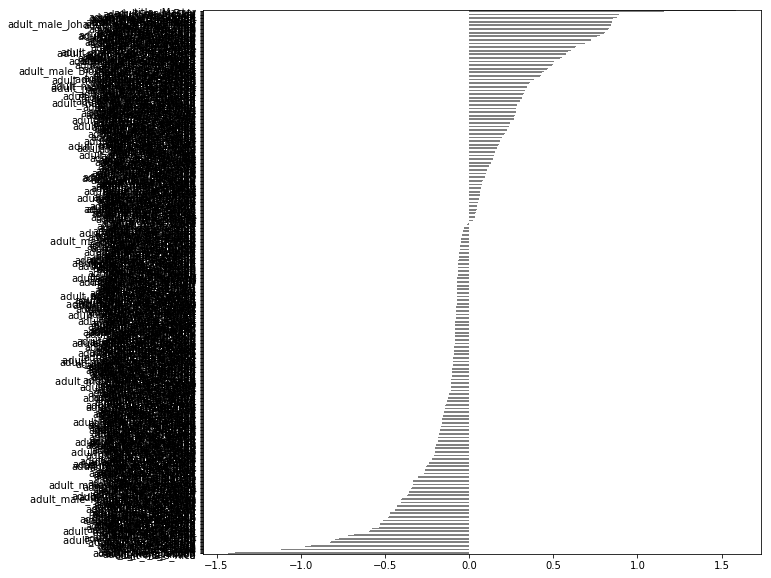

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

log_reg.fit(X_train_imputed, y_train)
coefficients = pd.Series(log_reg.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(10,10))
coefficients.sort_values().plot.barh(color='grey');

In [75]:
from sklearn.preprocessing import MinMaxScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = MinMaxScaler()
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)

X_train_encoded = encoder.fit_transform(X_train)
S_test_encoded = encoder.transform(X_test)

X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores.mean())

Cross-Validation Accuracy Scores 0.8282981500397231


In [76]:
pd.DataFrame(X_train_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.00000

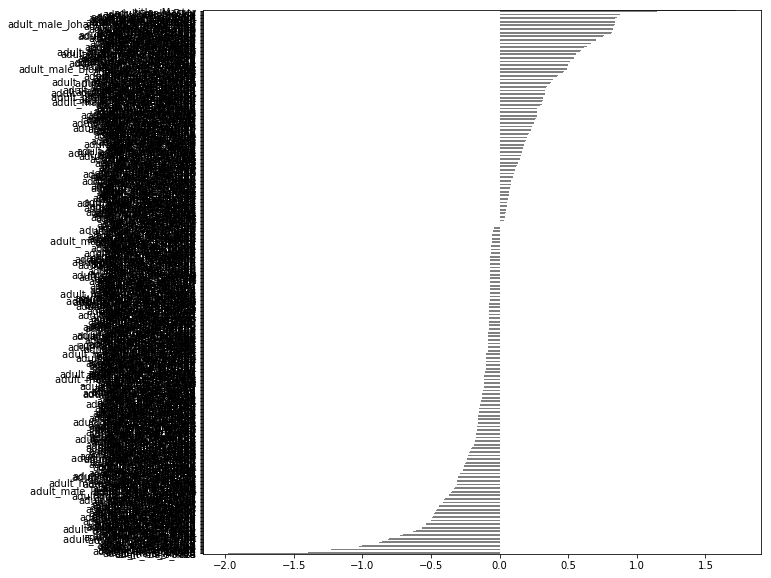

In [77]:
log_reg.fit(X_train_scaled, y_train)
coefficients = pd.Series(log_reg.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(10,10))
coefficients.sort_values().plot.barh(color='grey');

##pipeline

In [83]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    MinMaxScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

scores = cross_val_score(pipe, X_train, y_train, cv=10)
print('Cross-Validation scores:', scores.mean())

Cross-Validation scores: 0.8282981500397231


In [0]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

submission = test[['PassengerId']].copy()
submission['Survived'] = y_pred
submission.to_csv('kaggle-submission-001.csv', index=False)

## Assignment: real-world classification

We're going to check out a larger dataset - the [FMA Free Music Archive data](https://github.com/mdeff/fma). It has a selection of CSVs with metadata and calculated audio features that you can load and try to use to classify genre of tracks. To get you started:

### Get and unzip the data

#### Google Colab

In [59]:
!wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
!unzip fma_metadata.zip

--2019-05-09 23:09:23--  https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.13, 2001:620:5ca1:2ff::ce53
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358412441 (342M) [application/zip]
Saving to: ‘fma_metadata.zip.1’

fma_metadata.zip.1  100%[===================>] 341.81M  25.8MB/s    in 14s     

2019-05-09 23:09:37 (24.4 MB/s) - ‘fma_metadata.zip.1’ saved [358412441/358412441]

Archive:  fma_metadata.zip
replace fma_metadata/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace fma_metadata/checksums? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace fma_metadata/checksums? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace fma_metadata/not_found.pickle? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace fma_metadata/raw_genres.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
rep

#### Windows
- Download the [zip file](https://os.unil.cloud.switch.ch/fma/fma_metadata.zip)
- You may need to use [7zip](https://www.7-zip.org/download.html) to unzip it


#### Mac
- Download the [zip file](https://os.unil.cloud.switch.ch/fma/fma_metadata.zip)
- You may need to use [p7zip](https://superuser.com/a/626731) to unzip it

### Look at first 3 lines of raw file

In [60]:
!head -n 3 fma_metadata/tracks.csv

,album,album,album,album,album,album,album,album,album,album,album,album,album,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,set,set,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track
,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page,split,subset,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Read with pandas
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

tracks = pd.read_csv('fma_metadata/tracks.csv', header=[0,1], index_col=0)

pd.set_option('display.max_columns', 500)

In [62]:
tracks.shape

(106574, 52)

In [63]:
tracks.head()

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                                    <p></p>    6073   
10               4  6                                        NaN   47632   
20               2  4  <p> "spiritual songs" from Nicky Cook</p>    2710   

                                                            \
         producer tags                 title tracks   type   
track_id                                                     
2             NaN   []  AWOL - A Way Of Life      7  Album   
3             NaN   []  AWOL - A Way Of Life      7  Album   
5             NaN   []  AWOL - A Way Of Life      7  Album   
10            NaN   []     Constant Hitmaker      2  Album   
20            NaN   []                 Niris     13  Album   

                       artist                       \
            active_year_begin      active_year_end   
track_id                                             
2         2006-01-01 00:00:00                  NaN   
3         2006-01-01 00:00:00                  NaN   
5         2006-01-01 00:00:00                  NaN   
10                        NaN                  NaN   
20        1990-01-01 00:00:00  2011-01-01 00:00:00   

                                                             \
                                          associated_labels   
track_id                                                      
2                                                       NaN   
3                                                       NaN   
5                                                       NaN   
10        Mexican Summer, Richie Records, Woodsist, Skul...   
20                                                      NaN   

                                                                      \
                                                        bio comments   
track_id                                                               
2         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
3         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
5         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
10        <p><span style="font-family:Verdana, Geneva, A...        3   
20        <p>Songs written by: Nicky Cook</p>\n<p>VOCALS...        2   

                                                                           \
                 date_created favorites id   latitude            location   
track_id                                                                    
2         2008-11-26 01:42:32         9  1  40.058324          New Jersey   
3         2008-11-26 01:42:32         9  1  40.058324          New Jersey   
5         2008-11-26 01:42:32         9  1  40.058324          New Jersey   
10        2008-11-26 01:42:55        74  6        NaN                 NaN   
20        2008-11-26 01:42:52        10  4  51.895927  Colchester England   

                                                                        \
          longitude                                            members   
track_id                                         

In [64]:
tracks.isnull().sum()


album   comments                  0
        date_created           3529
        date_released         36280
        engineer              91279
        favorites                 0
        id                        0
        information           23425
        listens                   0
        producer              88514
        tags                      0
        title                  1025
        tracks                    0
        type                   6508
artist  active_year_begin     83863
        active_year_end      101199
        associated_labels     92303
        bio                   35418
        comments                  0
        date_created            856
        favorites                 0
        id                        0
        latitude              62030
        location              36364
        longitude             62030
        members               59725
        name                      0
        related_projects      93422
        tags                

In [0]:
tracks_base = tracks.dropna(subset=[('track', 'genre_top')])

In [66]:
tracks.shape, tracks_base.shape

((106574, 52), (49598, 52))

In [0]:
tracks_base.columns = tracks_base.columns.droplevel()

### Fit Logistic Regression!

In [69]:
target = 'genre_top'
features = ['duration','favorites']
y = tracks_base[target]
X = tracks_base[features]

def run_logistic_model(X, y):
    # Split into test and train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

    # Fit model using train data
    model = LogisticRegression(solver='lbfgs', multi_class='auto')
    model.fit(X_train, y_train)


    # Compare predictions to test target
    print('Accuracy: ', model.score(X_test, y_test))
    
run_logistic_model(X, y)

Accuracy:  0.31028225806451615


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


This dataset is bigger than many you've worked with so far, and while it should fit in Colab, it can take awhile to run. That's part of the challenge!

Your tasks:
- Clean up the variable names in the dataframe
- Use logistic regression to fit a model predicting (primary/top) genre
- Inspect, iterate, and improve your model
- Answer the following questions (written, ~paragraph each):
  - What are the best predictors of genre?
  - What information isn't very useful for predicting genre?
  - What surprised you the most about your results?

*Important caveats*:
- This is going to be difficult data to work with - don't let the perfect be the enemy of the good!
- Be creative in cleaning it up - if the best way you know how to do it is download it locally and edit as a spreadsheet, that's OK!
- If the data size becomes problematic, consider sampling/subsetting, or [downcasting numeric datatypes](https://www.dataquest.io/blog/pandas-big-data/).
- You do not need perfect or complete results - just something plausible that runs, and that supports the reasoning in your written answers

If you find that fitting a model to classify *all* genres isn't very good, it's totally OK to limit to the most frequent genres, or perhaps trying to combine or cluster genres as a preprocessing step. Even then, there will be limits to how good a model can be with just this metadata - if you really want to train an effective genre classifier, you'll have to involve the other data (see stretch goals).

This is real data - there is no "one correct answer", so you can take this in a variety of directions. Just make sure to support your findings, and feel free to share them as well! This is meant to be practice for dealing with other "messy" data, a common task in data science.

## Resources and stretch goals

- Check out the other .csv files from the FMA dataset, and see if you can join them or otherwise fit interesting models with them
- [Logistic regression from scratch in numpy](https://blog.goodaudience.com/logistic-regression-from-scratch-in-numpy-5841c09e425f) - if you want to dig in a bit more to both the code and math (also takes a gradient descent approach, introducing the logistic loss function)
- Create a visualization to show predictions of your model - ideally show a confidence interval based on error!
- Check out and compare classification models from scikit-learn, such as [SVM](https://scikit-learn.org/stable/modules/svm.html#classification), [decision trees](https://scikit-learn.org/stable/modules/tree.html#classification), and [naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html). The underlying math will vary significantly, but the API (how you write the code) and interpretation will actually be fairly similar.
- Sign up for [Kaggle](https://kaggle.com), and find a competition to try logistic regression with
- (Not logistic regression related) If you enjoyed the assignment, you may want to read up on [music informatics](https://en.wikipedia.org/wiki/Music_informatics), which is how those audio features were actually calculated. The FMA includes the actual raw audio, so (while this is more of a longterm project than a stretch goal, and won't fit in Colab) if you'd like you can check those out and see what sort of deeper analysis you can do.